In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import random, mlx_lm, math, scipy, pickle, os, sys, sklearn.linear_model, json
from dataclasses import dataclass
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from datasets import load_dataset
from sklearn.metrics import f1_score

sys.path.insert(0, os.path.join(os.getcwd(), "..", "support"))
import gemma2

# Setup

In [4]:
model, tokenizer = gemma2.load()

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

# Introduction

This tutorial is based on Li et al. "What do Language Models Learn in Context? The Structured Task Hypothesis" (https://arxiv.org/abs/2406.04216)

# Testing the Hypotheses

In [46]:
class Dataset:
  DEFAULTS = {
    "sst2":    ["Review: ",   "Sentiment: ",    ["negative", "positive"]],
    "sst5":    ["Review: ",   "Sentiment: ",    ["terrible", "bad", "okay", "good", "great"]],
    "CR":      ["Review: ",   "Sentiment: ",    ["negative", "positive"]],
    "ag_news": ["News: ",     "News type: ",    ["world", "sports", "business", "science"]],
    "dbpedia": ["Article: ",  "Article type: ", ["company", "school", "artist", "player", "politics", "transport", "building", "nature", "village", "animal", "plant", "album", "film", "book"]],
  }

  @staticmethod
  def load(name):
    fullname = {
      "sst2":    "SetFit/sst2",
      "sst5":    "SetFit/sst5",
      "CR":      "SetFit/CR",
      "ag_news": "ag_news",
      "dbpedia": "dbpedia_14"
    }[name]

    return Dataset(name, load_dataset(fullname)['train'])

  def __init__(self, name, ds):
    self.name = name
    self.ds   = ds
    with open("mappings.json", "r") as f:
      self.mappings = json.load(f)[name]

  @property
  def prompt_prefix(self):
    return self.DEFAULTS[self.name][0]

  @property
  def response_prefix(self):
    return self.DEFAULTS[self.name][1]

  @property
  def labels(self):
    return self.DEFAULTS[self.name][2]

  def map_label(self, mapping, label=None):
    if label is None:
      return lambda p, r=None: self.map_label(mapping, r or p)
    elif mapping is None:
      return label
    else:
      return self.mappings[mapping][label]

  def mapped_labels(self, mapping):
    return [self.map_label(mapping, l) for l in self.labels]

  def label_tokens(self, mapping=None):
    return [tokenizer.encode(self.map_label(mapping, l), add_special_tokens=False)[0] for l in self.labels]

  def build_task(self, n):
    ds     = self.ds.shuffle()
    data   = ds[:(n+1)]
    labels = [self.labels[l] for l in data['label']]
    return zip(data['text'][:-1], labels[:-1]), (data['text'][-1], labels[-1])
  
  def build_prompt(self, n, map_prompt=lambda p, r: p, map_response=lambda r: r):
    demonstration, n_plus_one = self.build_task(n)
    result = "\n".join([f"{self.prompt_prefix}{map_prompt(p, r)}\n{self.response_prefix}{map_response(r)}" for p, r in demonstration])
    return result + f"\n{self.prompt_prefix}{map_prompt(*n_plus_one)}\n{self.response_prefix}", map_response(n_plus_one[1])

## Task Selection Hypothesis

In [64]:
def evaluate_task_selection_hypothesis(ds_name, repeats, demo_lengths=[2,3,4,5,10,15,20,30,50]):
  def eval_for_mapping(ds, n, mapping):
    prompt, label = ds.build_prompt(n, map_response=ds.map_label(mapping))

    expected = ds.mapped_labels(mapping).index(label)
    logits   = model(mx.array(tokenizer.encode(prompt))[None])[0, -1, ds.label_tokens(mapping)]
    actual   = mx.argmax(logits).item()
    return expected, actual

  ds     = Dataset.load(ds_name)
  result = []
  for n in tqdm(demo_lengths):
    baseline = np.array([eval_for_mapping(ds, n, None)     for _ in range(repeats)])
    mapped   = np.array([eval_for_mapping(ds, n, "labels") for _ in range(repeats)])
    result.append((n, f1_score(baseline[:, 1], baseline[:, 0], average='macro'), f1_score(mapped[:, 1], mapped[:, 0], average='macro')))
  return np.array(result)

task_selection_CR      = evaluate_task_selection_hypothesis("CR", 200)
task_selection_sst2    = evaluate_task_selection_hypothesis("sst2", 200)
task_selection_ag_news = evaluate_task_selection_hypothesis("ag_news", 200)

Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 9/9 [1:40:54<00:00, 672.70s/it]
Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 9/9 [2:49:03<00:00, 1127.11s/it]


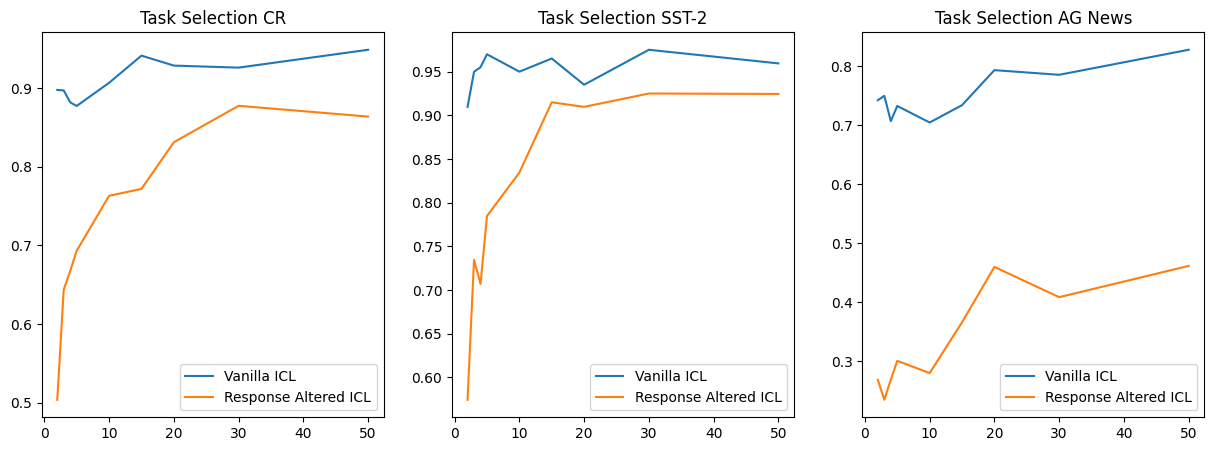

In [65]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each array in a separate subplot
axs[0].plot(task_selection_CR[:, 0], task_selection_CR[:, 1], label='Vanilla ICL')
axs[0].plot(task_selection_CR[:, 0], task_selection_CR[:, 2], label='Response Altered ICL')
axs[0].set_title('Task Selection CR')
axs[0].legend()

axs[1].plot(task_selection_sst2[:, 0], task_selection_sst2[:, 1], label='Vanilla ICL')
axs[1].plot(task_selection_sst2[:, 0], task_selection_sst2[:, 2], label='Response Altered ICL')
axs[1].set_title('Task Selection SST-2')
axs[1].legend()

axs[2].plot(task_selection_ag_news[:, 0], task_selection_ag_news[:, 1], label='Vanilla ICL')
axs[2].plot(task_selection_ag_news[:, 0], task_selection_ag_news[:, 2], label='Response Altered ICL')
axs[2].set_title('Task Selection AG News')
axs[2].legend()

# Display the plot
plt.show()

## Meta-Learning Hypothesis

## Experiment 1

we now modify the prompt, but keep the response. we do the prompt modification in a learnable manner. in particular we implement a simple replacement cypher, that is for every token in the vocabulary we chooe a random other token.

TODO: try this with SAE features. ie check the SAE features for a very early layer, see if there is a shuffling of tokens that preserves the relationship of features between inputs and preserves the output. switching tokens removes too much of the meaning. maybe the model can't do linear regression on random tokens, but maybe on features.

In [90]:
def eval_meta_learning(ds, n, repeats):
  crypter = list(range(model.vocab_size))
  random.shuffle(crypter)
  for t in ds.label_tokens():
    crypter[t] = t

  def eval_prompt():
    prompt, label = ds.build_prompt(n)

    expected = ds.labels.index(label)
    tokens   = mx.array([crypter[t] for t in tokenizer.encode(prompt)])
    logits   = model(mx.array(tokenizer.encode(prompt))[None])[0, -1, ds.label_tokens()]
    actual   = mx.argmax(logits).item()
    return expected, actual

  return np.array([eval_prompt() for _ in range(repeats)])

baseline = [eval_meta_learning(ds, i, 100) for i in tqdm([1,2,3,4,5,10,15,20,30,50])]
plt.plot([f1_score(e[:, 0], e[:, 1], average='macro') for e in baseline])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'ds' is not defined

100%|██████████| 9/9 [1:48:29<00:00, 723.27s/it]


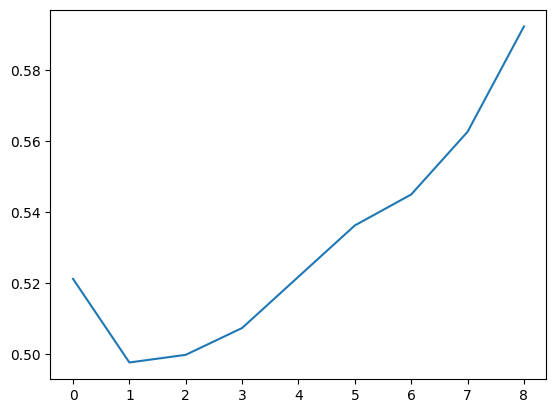

In [25]:
def eval_linear_model(ds, n, repeats):
  def vectorize(train, test, **vecargs):
     from sklearn.feature_extraction.text import CountVectorizer
     vectorizer = CountVectorizer(strip_accents='unicode', **vecargs)
     vectorizer.fit(train)
     return vectorizer.transform(train), vectorizer.transform(test)

  def train_and_eval_lr():
    Y_test = ds["test"]["label"]
    test   = ds["test"]["text"]

    for i in range(10): # give it ten tries, otherwise fail
      slice   = ds["train"].shuffle()[:n]
      Y_train = slice["label"]
      train   = slice["text"]
      if len(set(Y_train)) == 2:
        break

      if i == 9:
        raise ValueError("Could not find a valid training set")

    results = []
    for cs in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]:
      for solver in ['lbfgs', 'saga', 'sag']:
        for ngc_max in [1, 2, 3, 4]:
          for ngw_max in [1, 2]:
            word_train, word_test = vectorize(train, test, analyzer='word', max_features=10000, ngram_range=(1, ngw_max), token_pattern=r'\w{1,}', stop_words='english')
            char_train, char_test = vectorize(train, test, analyzer='char', max_features=50000, ngram_range=(1, ngc_max))
            X_train = scipy.sparse.hstack([word_train, char_train])
            X_test  = scipy.sparse.hstack([word_test, char_test])

            lr = sklearn.linear_model.LogisticRegression(C=cs, solver=solver, max_iter=10000)
            lr.fit(X_train, Y_train)

            Y_pred = lr.predict(X_test)
            results.append(f1_score(Y_test, Y_pred, average='macro'))
    return max(results)
  
  return np.mean([train_and_eval_lr() for _ in range(repeats)])

linear_learning = [eval_linear_model(ds, i, 100) for i in tqdm([2,3,4,5,10,15,20,30,50])]
plt.plot(linear_learning)
plt.show()

## Experiment 2

In this experiment we evaluate whether the model can ICL via linear regression, as suggested by some other authors. To do this we use a prompt and response format that consists of single tokens. We only use the labels from our dataset and we replace each label with a random token.

In [1]:
CLEAN_TOKENS = [i for i in range(model.vocab_size) if len(tokenizer.encode(tokenizer.decode(i), add_special_tokens=False)) == 1]

NameError: name 'model' is not defined

In [92]:
def eval_linear_meta_learning(options, L=32, repeats=100):
  def prepare_task():
    X      = [random.randint(0, len(options) - 1) for _ in range(L)]
    x_test = random.randint(0, len(options) - 1)
    return X, x_test

  def eval_llm(X, x_test, labels):
    ltexts = [tokenizer.decode(l) for l in labels]
    prompt = ""
    for x in X:
      prompt += f"Review: {options[x]}\n"
      prompt += f"Sentiment: {ltexts[x]}\n"

    prompt += f"Review: {options[x_test]}\n"
    prompt += f"Sentiment: "

    logits = model(mx.array(tokenizer.encode(prompt))[None])
    outids = [tokenizer.encode(o, add_special_tokens=False)[0] for o in options]
    return mx.argmax(logits[0, -1, outids]).item()

  def eval_lr(X, x_test, labels, num_epochs=80, lr=1000):
    P = model.embed_tokens(mx.array([labels[x] for x in X]))
    R = model.embed_tokens(mx.array([tokenizer.encode(options[x], add_special_tokens=False)[0] for x in X]))

    linear       = nn.Linear(model.hidden_size, model.hidden_size)
    optimizer    = optim.SGD(learning_rate=lr)
    loss_grad_fn = nn.value_and_grad(linear, lambda m, P, R: mx.mean((m(P) - R) ** 2))

    for _ in range(num_epochs):
      loss, grads = loss_grad_fn(linear, P, R)
      optimizer.update(linear, grads)
      mx.eval(linear.parameters(), optimizer.state)

    p_test = model.embed_tokens.weight[labels[x_test]]
    r_star = np.array(linear(p_test))
    return X[np.argmax(np.dot(r_star, np.array(R).T))]

  def eval_task():
    result = []
    labels = random.sample(CLEAN_TOKENS, len(options))
    for _ in range(repeats):
      X, x_test = prepare_task()
      y_llm     = eval_llm(X, x_test, labels)
      y_lr      = eval_lr(X, x_test, labels)
      result.append((x_test, y_llm, y_lr))
    return np.array(result)
  
  return np.array([eval_task() for _ in tqdm(list(range(50)))])

x = eval_linear_meta_learning(["positive", "negative"])
x


  0%|          | 0/50 [00:37<?, ?it/s]


KeyboardInterrupt: 

## Structured Task Hypothesis

## Experiment 1

evaluate the correlation between eval_task_selection and eval_meta_learning. this is predicted to be high if task is learned by composition

## Experiment 2

construct natural mappings, that are likely to have occurred in the training. that is rather than picking random labels, we choose: synonyms, antonyms and keywords from the relevant domain

In [104]:
def eval_prompt_mapping(ds, mapping, num_tasks, repeats, n=5, additional=None):
  def make_task_mapper():
    task = { l: random.choice(mapping[l]) for l in ds.labels }
    return lambda p, r: task[r]

  results = []
  for _ in tqdm(list(range(num_tasks))):
    mapper = make_task_mapper()
    epoch  = []
    for _ in range(repeats):
      prompt, label = ds.build_prompt(n, map_prompt=mapper)

      expected = ds.mapped_labels(mapping).index(label)
      logits   = model(mx.array(tokenizer.encode(prompt))[None])[0, -1, ds.label_tokens(mapping)]
      actual   = mx.argmax(logits).item()

      epoch.append((expected, actual))
    results.append(epoch)
  return np.array(results)

100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


array([[[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0]],

       [[1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [0, 0]],

       [[0, 0],
        [0, 0],


In [108]:
CR_random_results   = eval_prompt_mapping({ "negative": CLEAN_TOKENS, "positive": CLEAN_TOKENS }, 50, 100)
CR_keywords_results = eval_prompt_mapping(CR_keywords, 50, 100)

100%|██████████| 50/50 [23:30<00:00, 28.21s/it]


In [109]:
CR_random_scores   = np.array([f1_score(CR_random_results[:, i, 0], CR_random_results[:, i, 1], average='macro') for i in range(CR_random_results.shape[1])])
CR_keywords_scores = np.array([f1_score(CR_keywords_results[:, i, 0], CR_keywords_results[:, i, 1], average='macro') for i in range(CR_keywords_results.shape[1])])


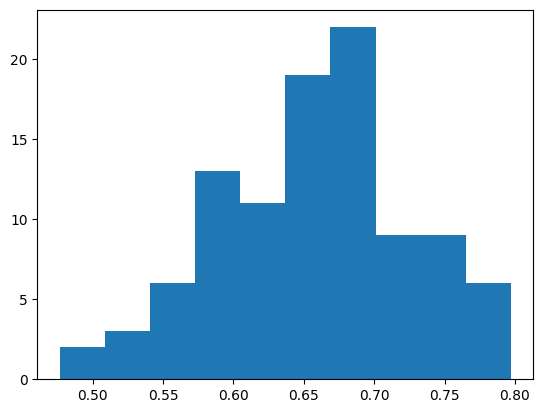

In [111]:
plt.hist(CR_random_scores)
plt.show()

In [113]:
np.mean(CR_random_scores), np.var(CR_random_scores)

(np.float64(0.6576944067154148), np.float64(0.004760197819399048))

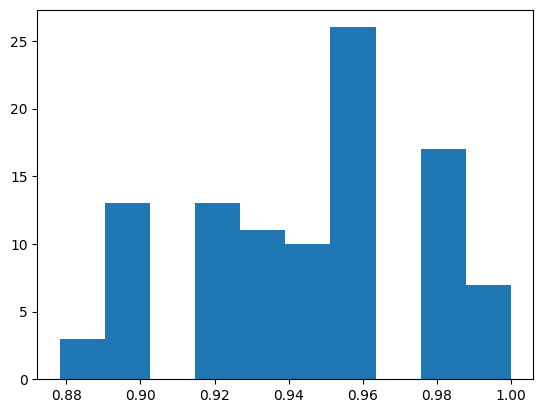

In [112]:
plt.hist(CR_keywords_scores)
plt.show()

In [114]:
np.mean(CR_keywords_scores), np.var(CR_keywords_scores)

(np.float64(0.9455639461754413), np.float64(0.0009942646013466345))

## Experiment 3

construct mappings that seem arbitrary, but are still likely to be part of the training set. we do this by defining a hierachy of mappings based on successive levels of synonyms

In [127]:
def build_synonym_hierachy(initials, depth, breadth=10):
  def first_n_unique(items, n):
    seen = set()
    return [x for x in items if not (x in seen or seen.add(x))][:n]

  from PyMultiDictionary import MultiDictionary
  dictionary = MultiDictionary()

  result = { o: [] for o in initials }
  for o in initials:
    current = [o]
    for _ in range(depth):
      existing   = set(current).union(set(sum(result[o], [])))
      candidates = sum([list(set(dictionary.synonym("en", c)) - existing) for c in current], [])
      current    = first_n_unique(sorted(candidates, key=lambda x: candidates.count(x), reverse=True), breadth)
      result[o].append(current)
  return result

In [129]:
def evaluate_synomym_hierachy(ds_name, depth, num_tasks, repeats, L=5):
  ds       = Dataset.load(ds_name)
  hierachy = build_synonym_hierachy(ds.labels, depth)
  result   = []
  for i in tqdm(list(range(depth))):
    mapping    = { l: hierachy[l][i] for l in ds.labels }
    evaluation = eval_prompt_mapping(mapping, num_tasks, repeats)
    scores     = np.array([f1_score(evaluation[:, i, 0], evaluation[:, i, 1], average='macro') for i in range(evaluation.shape[1])])
    result.append(scores)
  return np.array(result)
x = evaluate_synomym_hierachy("CR", 6, 50, 100)
x

100%|██████████| 6/6 [1:53:42<00:00, 1137.05s/it]


array([[0.89665151, 0.85858586, 0.83579639, 0.85720114, 0.83001457,
        0.8389694 , 0.89995998, 0.81992797, 0.91883117, 0.83766234,
        0.9194847 , 0.92      , 0.95833333, 0.85720114, 0.91319444,
        0.87922705, 0.8389694 , 0.93939394, 0.8989899 , 0.95941558,
        0.87922705, 0.88      , 0.89010989, 0.85531211, 0.85994398,
        0.8996387 , 0.85949418, 0.81992797, 0.93997599, 0.85994398,
        0.91789819, 0.89665151, 0.79967949, 0.77991196, 0.84615385,
        0.85994398, 0.93799091, 0.89665151, 0.87980769, 0.87684729,
        0.91883117, 0.87922705, 0.81992797, 0.77263332, 0.87922705,
        0.91789819, 0.85949418, 0.86666667, 0.80952381, 0.86213235,
        0.93880049, 0.84984985, 0.8989899 , 0.9194847 , 0.91789819,
        0.87922705, 0.8996387 , 0.8989899 , 0.88312295, 0.85994398,
        0.91087344, 0.79871176, 0.84984985, 0.88312295, 0.85720114,
        0.84615385, 0.79474548, 0.875     , 0.83333333, 0.81992797,
        0.81992797, 0.93939394, 0.87922705, 0.89